### 1. Importing Packages and Loading Data

In [1]:
import pandas as pd
from zipfile import ZipFile
import os
 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import math

In [2]:
file_path = './iranian+churn+dataset.zip'

with ZipFile(file_path) as z:
    print(z.namelist())

filename = z.namelist()[0]
with ZipFile(file_path).open(filename) as f:
    df = pd.read_csv(f)

['Customer Churn.csv']


In [3]:
df.drop(columns=['Age'], inplace=True)
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,145.805,0


### 2. Splitting Data into Train and Test Sets

In [4]:
X = df.drop(columns = ['Churn']) # dataframe
y = df['Churn'] # series

# Use stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=312, stratify=y)

print(f'# of train samples: {len(X_train)}')
print(f'# of test samples: {len(X_test)}')

X_train.head()

# of train samples: 2520
# of test samples: 630


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Customer Value
2453,17,0,43,1,4683,80,19,42,1,1,1,366.465
3117,7,0,40,0,1015,20,20,10,3,1,2,121.400
1492,3,0,20,0,740,18,1,6,2,1,1,38.610
143,0,0,23,0,3165,58,3,21,3,1,1,140.920
1068,0,0,35,0,0,0,0,0,2,1,2,0.000


### 3. Tree Classifiers

#### 3.1 Setting Custom Cross-Validation Methods

In [5]:
metric_list = ['accuracy', 'precision', 'recall', 'f1_score']

def matrix_to_metrics(mat):
    TP = mat[1, 1]
    TN = mat[0, 0]
    FP = mat[0, 1]
    FN = mat[1, 0]
    
    acc = (TP + TN) / (TP + TN + FP + FN)
    prec = TP / (TP + FP) 
    rec = TP / (TP + FN)
    f1_score = 2 * (prec * rec) / (prec + rec)
    
    return [acc, prec, rec, f1_score]

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [7]:
from sklearn.model_selection import KFold
import time
import datetime
from sklearn.metrics import confusion_matrix

In [8]:
def cross_validate(data, model_class, model_params, drops):
    result_dict = {} 
    feature_importances_list = []
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for m in metrics:
        result_dict[m] = []

    X_train, y_train = data
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    X_train = X_train.drop(columns=drops, axis=1)

    start_time = time.time()
    
    for fold in kf.split(X_train): 
        trn_idx, val_idx = fold
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx] # analysis set 
        y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx] # assessment set
        
        # model fitting
        model = model_class(**model_params)
        model.fit(X_trn, y_trn)

        # feature importance
        feature_importances_list.append(model.feature_importances_)
        
        # model evaluation
        y_pred = model.predict(X_val)
        conf_mat = confusion_matrix(y_val, y_pred)
        fold_result = matrix_to_metrics(conf_mat)
        for i, val in enumerate(fold_result):
            result_dict[metrics[i]].append(round(fold_result[i], 4))
            
    end_time = time.time() 
    elapsed_time = end_time - start_time
    readable_time = f"{elapsed_time:.3f} seconds"
    print(readable_time)

    for key in result_dict:
        result_dict[key].append({'average': round(sum(result_dict[key]) / len(result_dict[key]), 3)})

    average_importances = np.mean(feature_importances_list, axis=0)
    importances_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': average_importances
    })
    importances_df.sort_values(by='Importance', ascending=False, inplace=True)
        
    return result_dict, importances_df

#### 3.2 Preliminary Results

In [9]:
def get_summary(result_dict):
    cols = []
    avgs = []
    for key in result_dict:
        cols.append(key)
        avgs.append(result_dict[key][-1]['average'])
    return pd.DataFrame({'Metric': cols, 'Average': avgs}) 

In [10]:
def compare_models(df_dict): 
    n = len(df_dict)
    for idx, item in enumerate(df_dict.items()):
        model_name, result = item
        if idx == 0:
            merged_df = result.rename(columns={'Average': model_name})
        else:
            merged_df = pd.merge(merged_df, result.rename(columns={'Average': model_name}), on='Metric')

    merged_df = merged_df.set_index('Metric')
    merged_df['best_model'] = merged_df.idxmax(axis=1)
    
    return merged_df

In [11]:
model_class_dict = {}
model_class_dict['DecisionTree'] = DecisionTreeClassifier
model_class_dict['RandomForest'] = RandomForestClassifier
model_class_dict['ExtraTrees'] = ExtraTreesClassifier
model_class_dict['XGBoost'] =  XGBClassifier
model_class_dict['LightGBM'] = LGBMClassifier
model_class_dict['CatBoost'] = CatBoostClassifier

In [12]:
def run_tree(model_dict):
    result_dict = {}
    feat_info = {}
    for name in model_dict:
        print(name, '='* (20-len(name)))
        data = model_dict[name]['data']
        model_class = model_dict[name]['class']
        model_params= model_dict[name]['param']
        drops = model_dict[name]['drop']
        single_result, single_feat_info = cross_validate(data, model_class, model_params, drops)
        result_dict[name] = get_summary(single_result)   
        feat_info[name] = single_feat_info
    return result_dict, feat_info

In [13]:
tree_dict = {}
for mc in model_class_dict:
    tree_dict[mc] = {}
    cur_dict = tree_dict[mc]    
    cur_dict['data'] = [X_train, y_train]
    cur_dict['class'] = model_class_dict[mc]
    if mc == 'CatBoost':
        cur_dict['param'] = {'verbose': False}
    else:
        cur_dict['param'] = {}
    cur_dict['drop'] = []

In [14]:
tree_results, tree_feats = run_tree(tree_dict)

DecisionTree ========
0.030 seconds
RandomForest ========
0.612 seconds
ExtraTrees ==========
0.403 seconds
XGBoost =============
0.428 seconds
LightGBM ============
1.264 seconds
CatBoost ============
3.977 seconds


In [15]:
compare_models(tree_results)

,DecisionTree,RandomForest,ExtraTrees,XGBoost,LightGBM,CatBoost,best_model
Metric,,,,,,,
accuracy,0.937,0.956,0.960,0.959,0.963,0.959,LightGBM
precision,0.812,0.895,0.915,0.896,0.903,0.902,ExtraTrees
recall,0.786,0.822,0.823,0.843,0.857,0.835,LightGBM
f1_score,0.796,0.856,0.865,0.867,0.878,0.866,LightGBM


In [16]:
tree_feats['LightGBM']

,Feature,Importance
2,Subscription Length,517.8
4,Seconds of Use,498.4
5,Frequency of use,454.6
11,Customer Value,310.4
0,Call Failure,282.2
6,Frequency of SMS,258.8
7,Distinct Called Numbers,250.2
8,Age Group,196.6
1,Complains,104.8
10,Status,85.6


In [17]:
# Removing variables with zero importance
lgbm_wrapper = {}
lgbm_wrapper['drop'] = {}
cur_dict = lgbm_wrapper['drop']   
cur_dict['data'] = [X_train, y_train]
cur_dict['class'] = LGBMClassifier
cur_dict['param'] = {}
cur_dict['drop'] = ['Tariff Plan']

In [18]:
lgbm_results, lgbm_feats = run_tree(lgbm_wrapper)

drop ================
1.266 seconds


In [19]:
lgbm_results['drop'] # classification performance remained unchanged after removal

,Metric,Average
0,accuracy,0.963
1,precision,0.903
2,recall,0.857
3,f1_score,0.878


In [20]:
lgbm_feats['drop'] # variable importance remained unchanged after removal

,Feature,Importance
2,Subscription Length,517.8
4,Seconds of Use,498.4
5,Frequency of use,454.6
10,Customer Value,310.4
0,Call Failure,282.2
6,Frequency of SMS,258.8
7,Distinct Called Numbers,250.2
8,Age Group,196.6
1,Complains,104.8
9,Status,85.6


#### 3.3 Handling Class Imbalance

In [21]:
# SMOTE
def smote_cross_validate(data, model_class, model_params, drops):
    result_dict = {} 
    feature_importances_list = []
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for m in metrics:
        result_dict[m] = []

    X_train, y_train = data
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    X_train = X_train.drop(columns=drops, axis=1)

    start_time = time.time()
    
    for fold in kf.split(X_train): 
        trn_idx, val_idx = fold
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx] # analysis set 
        y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx] # assessment set

        # smote
        cate = ['Complains', 'Charge  Amount', 'Age Group', 'Status']
        smote_nc = SMOTENC(categorical_features=cate, random_state=42)
        X_trn, y_trn = smote_nc.fit_resample(X_trn, y_trn)
        
        # model fitting
        model = model_class(**model_params)
        model.fit(X_trn, y_trn)

        # feature importance
        feature_importances_list.append(model.feature_importances_)
        
        # model evaluation
        y_pred = model.predict(X_val)
        conf_mat = confusion_matrix(y_val, y_pred)
        fold_result = matrix_to_metrics(conf_mat)
        for i, val in enumerate(fold_result):
            result_dict[metrics[i]].append(round(fold_result[i], 4))
            
    end_time = time.time() 
    elapsed_time = end_time - start_time
    readable_time = f"{elapsed_time:.3f} seconds"
    print(readable_time)

    for key in result_dict:
        result_dict[key].append({'average': round(sum(result_dict[key]) / len(result_dict[key]), 3)})

    average_importances = np.mean(feature_importances_list, axis=0)
    importances_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': average_importances
    })
    importances_df.sort_values(by='Importance', ascending=False, inplace=True)
        
    return result_dict, importances_df

In [22]:
from imblearn.over_sampling import SMOTENC

def run_smote(model_dict):
    result_dict = {}
    feat_info = {}
    for name in model_dict:
        print(name, '='* (20-len(name)))
        data = model_dict[name]['data']
        model_class = model_dict[name]['class']
        model_params= model_dict[name]['param']
        drops = model_dict[name]['drop']
        single_result, single_feat_info = smote_cross_validate(data, model_class, model_params, drops)
        result_dict[name] = get_summary(single_result)   
        feat_info[name] = single_feat_info
    return result_dict, feat_info

In [23]:
lgbm_smote_results, lgbm_smote_feats = run_smote(lgbm_wrapper)

drop ================
1.625 seconds


In [24]:
lgbm_smote_results['drop'] # recall increased, but all other metrics declined

,Metric,Average
0,accuracy,0.952
1,precision,0.806
2,recall,0.915
3,f1_score,0.856


In [25]:
lgbm_smote_feats['drop'] # variable importance varies with smote

,Feature,Importance
4,Seconds of Use,558.8
2,Subscription Length,457.2
5,Frequency of use,398.0
10,Customer Value,360.0
6,Frequency of SMS,292.0
0,Call Failure,284.4
7,Distinct Called Numbers,251.4
8,Age Group,197.0
1,Complains,102.4
9,Status,74.4


In [26]:
# Model Weight Adjustment
lgbm_weight_wrapper = {}
lgbm_weight_wrapper['drop'] = {}
cur_dict = lgbm_weight_wrapper['drop']   
cur_dict['data'] = [X_train, y_train]
cur_dict['class'] = LGBMClassifier
cur_dict['param'] = {'is_unbalance': True}
cur_dict['drop'] = ['Tariff Plan']

In [27]:
lgbm_weight_results, lgbm_weight_feats = run_tree(lgbm_weight_wrapper)

drop ================
1.272 seconds


In [28]:
lgbm_weight_results['drop']

,Metric,Average
0,accuracy,0.958
1,precision,0.849
2,recall,0.894
3,f1_score,0.870


In [29]:
lgbm_weight_feats['drop']

,Feature,Importance
2,Subscription Length,524.2
4,Seconds of Use,500.8
5,Frequency of use,441.8
10,Customer Value,295.8
0,Call Failure,286.6
6,Frequency of SMS,261.2
7,Distinct Called Numbers,259.8
8,Age Group,198.8
1,Complains,109.6
9,Status,82.8


#### 3.4 Summary of CV Results

In [30]:
def summarize(df_dict):
    merged_df = pd.DataFrame()
    for key, df in df_dict.items():
        df_renamed = df.rename(columns={'Average': key})
        if merged_df.empty:
            merged_df = df_renamed
        else:
            merged_df = pd.merge(merged_df, df_renamed, on='Metric')
    return merged_df

In [31]:
trees = compare_models(tree_results).drop(columns=['best_model'])
df_dict = {}
df_dict['drop'] = lgbm_results['drop']
df_dict['drop_smote'] = lgbm_smote_results['drop']
df_dict['drop_weight'] = lgbm_weight_results['drop']

In [32]:
summary = summarize(df_dict)
summary

,Metric,drop,drop_smote,drop_weight
0,accuracy,0.963,0.952,0.958
1,precision,0.903,0.806,0.849
2,recall,0.857,0.915,0.894
3,f1_score,0.878,0.856,0.870


In [33]:
from functools import reduce
dfs = [trees, summary]
merged_df_final = reduce(lambda left, right: pd.merge(left, right, on='Metric'), dfs)
merged_df_final.set_index('Metric', inplace=True)
merged_df_final['best_model'] = merged_df_final.idxmax(axis=1)

In [34]:
merged_df_final

,DecisionTree,RandomForest,ExtraTrees,XGBoost,LightGBM,CatBoost,drop,drop_smote,drop_weight,best_model
Metric,,,,,,,,,,
accuracy,0.937,0.956,0.960,0.959,0.963,0.959,0.963,0.952,0.958,LightGBM
precision,0.812,0.895,0.915,0.896,0.903,0.902,0.903,0.806,0.849,ExtraTrees
recall,0.786,0.822,0.823,0.843,0.857,0.835,0.857,0.915,0.894,drop_smote
f1_score,0.796,0.856,0.865,0.867,0.878,0.866,0.878,0.856,0.870,LightGBM


#### 3.5 Threshold Adjustment

In [35]:
from sklearn.metrics import roc_curve, auc, classification_report

In [36]:
def curve_cross_validate(data, model_class, model_params, drops):
    result_dict = {} 
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for m in metrics:
        result_dict[m] = []

    X_train, y_train = data
    X_train = X_train.drop(columns=drops, axis=1)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(8, 6))
    
    start_time = time.time()
    
    for fold_idx, fold in enumerate(kf.split(X_train)): 
        trn_idx, val_idx = fold
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx] # analysis set 
        y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx] # assessment set
        
        # model fitting
        model = model_class(**model_params)
        model.fit(X_trn, y_trn)
        
        # model evaluation
        y_pred = model.predict(X_val)
        conf_mat = confusion_matrix(y_val, y_pred)
        fold_result = matrix_to_metrics(conf_mat)
        for i, val in enumerate(fold_result):
            result_dict[metrics[i]].append(round(fold_result[i], 4))

        y_pred_proba = model.predict_proba(X_val)[:, 1]
        # ROC 곡선과 AUC 계산
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # ROC 커브 그리기
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold_idx+1} (AUC = {roc_auc:.2f})')
    
        # 보간법으로 TPR 저장 (평균 ROC 계산에 사용)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        # 최적 임계값 선택
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        print(f"\nOptimal threshold based on ROC curve: {optimal_threshold:.2f}")
        
        # 최적 임계값으로 예측
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
        print("\nClassification report with optimal threshold:\n")
        print(classification_report(y_val, y_pred_optimal))
            
    end_time = time.time() 
    elapsed_time = end_time - start_time
    readable_time = f"{elapsed_time:.3f} seconds"
    print(readable_time)

    for key in result_dict:
        result_dict[key].append({'average': round(sum(result_dict[key]) / len(result_dict[key]), 3)})

    # 평균 ROC 곡선 및 AUC 계산
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2)
    
    # 대각선 기준선 그리기
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curves for Each Fold')
    plt.legend(loc="lower right")
    plt.show()
        
    return result_dict

In [37]:
def run_threshold(model_dict):
    result_dict = {}
    feat_info = {}
    for name in model_dict:
        print(name, '='* (20-len(name)))
        data = model_dict[name]['data']
        model_class = model_dict[name]['class']
        model_params= model_dict[name]['param']
        drops = model_dict[name]['drop']
        single_result = curve_cross_validate(data, model_class, model_params, drops)
        result_dict[name] = get_summary(single_result)   
    return result_dict

In [38]:
lgbm_wrapper = {}
lgbm_wrapper['drop'] = {}
cur_dict = lgbm_wrapper['drop']   
cur_dict['data'] = [X_train, y_train]
cur_dict['class'] = LGBMClassifier
cur_dict['param'] = {}
cur_dict['drop'] = ['Tariff Plan']

drop ================

Optimal threshold based on ROC curve: 0.26

Classification report with optimal threshold:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       418
           1       0.90      0.90      0.90        86

    accuracy                           0.96       504
   macro avg       0.94      0.94      0.94       504
weighted avg       0.96      0.96      0.96       504


Optimal threshold based on ROC curve: 0.11

Classification report with optimal threshold:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       432
           1       0.83      0.97      0.90        72

    accuracy                           0.97       504
   macro avg       0.91      0.97      0.94       504
weighted avg       0.97      0.97      0.97       504


Optimal threshold based on ROC curve: 0.01

Classification report with optimal threshold:

              precision    recall  f1-score   su

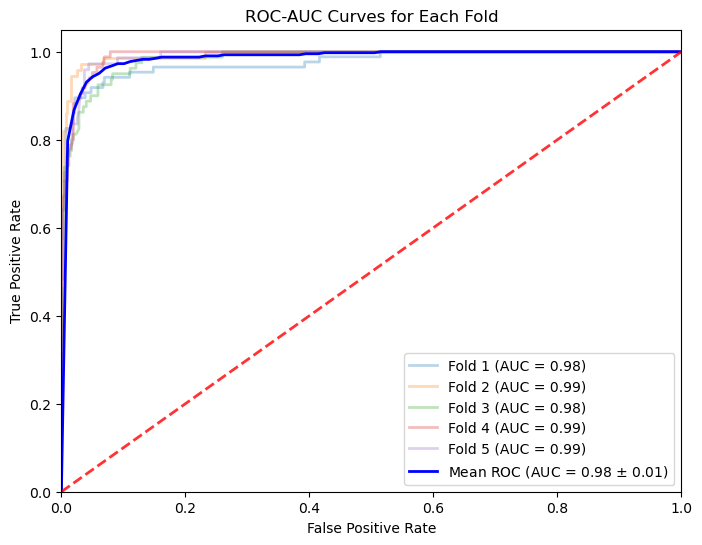

In [39]:
lgbm_result = run_threshold(lgbm_wrapper)

#### 3.6 Final Results

In [40]:
def train(data, model_class, model_params, drops):
    result_dict = {} 
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for m in metrics:
        result_dict[m] = []

    [X_train, y_train, X_test, y_test] = data

    model = model_class(**model_params)
    model.fit(X_train, y_train)
        
    #y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # 임계값을 적용하여 최종 예측
    threshold = 0.2
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    conf_mat = confusion_matrix(y_test, y_pred)
    final_result = matrix_to_metrics(conf_mat)
    for i, val in enumerate(final_result):
        result_dict[metrics[i]].append(round(final_result[i], 4))
        
    end_time = time.time() 
    elapsed_time = end_time - start_time
    readable_time = f"{elapsed_time:.3f} seconds"
    print(readable_time)

    return result_dict

In [41]:
def run(model_dict):
    result_dict = {}
    for name in model_dict:
        print(name, '='* (20-len(name)))
        data = model_dict[name]['data']
        model_class = model_dict[name]['class']
        model_params= model_dict[name]['param']
        drops = model_dict[name]['drop']
        single_result = train(data, model_class, model_params, drops)
        result_dict[name] = single_result 
    return result_dict

In [42]:
lgbm_wrapper = {}
lgbm_wrapper['drop'] = {}
cur_dict = lgbm_wrapper['drop']   
cur_dict['data'] = [X_train, y_train, X_test, y_test]
cur_dict['class'] = LGBMClassifier
cur_dict['param'] = {}
cur_dict['drop'] = ['Tariff Plan']

In [43]:
final_result = run(lgbm_wrapper)

drop ================
0.271 seconds


In [44]:
pd.DataFrame(final_result['drop'])

,accuracy,precision,recall,f1_score
0,0.9698,0.8704,0.9495,0.9082


### 4. Neural Net 

#### 4.1 Vanilla Result

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, WeightedRandomSampler

from sklearn.base import BaseEstimator, ClassifierMixin

In [46]:
class BinaryClassificationNet(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [47]:
def nn_cross_validate(data, trainer, drops, scaler):
    result_dict = {} 
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for m in metrics:
        result_dict[m] = []

    X_train, y_train = data
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # removing correlated columns
    X_train = X_train.drop(columns=drops, axis=1)

    start_time = time.time()
    
    for idx, fold in enumerate(kf.split(X_train)): 
        trn_idx, val_idx = fold
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx] # analysis set 
        y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx] # assessment set

        # scaling
        if scaler is not None:   
            # previous parameters not retained
            X_trn = scaler.fit_transform(X_trn)  
            X_val = scaler.transform(X_val) 
            
        # converting to tensor
        X_trn = torch.tensor(X_trn, dtype=torch.float32) 
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_trn = torch.tensor(y_trn.to_numpy(), dtype= torch.float32).view(-1, 1)

        # data loading
        train_dataset = TensorDataset(X_trn, y_trn)
        train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
        
        val_dataset = TensorDataset(X_val)
        val_loader = DataLoader(dataset=val_dataset, batch_size=32)

        # model fitting
        fold_train = trainer(BinaryClassificationNet, input_dim=len(X_train.columns))
        model = fold_train.model
        model.train() 

        for epoch in range(fold_train.epochs):
            epoch_loss = 0
            for batch in train_loader:
                x_batch, y_batch = batch
                fold_train.optimizer.zero_grad()
                outputs = model(x_batch)
                loss = fold_train.criterion(outputs, y_batch)
                loss.backward()
                fold_train.optimizer.step() 
                epoch_loss += loss.item()
            if (epoch + 1) != 0 and (epoch + 1) % 10 == 0:
                print(f'Fold [{idx+1}/5], Epoch [{epoch+1}/{fold_train.epochs}], Loss: {epoch_loss/len(train_loader):.4f}')
        
        # model evaluation
        preds = []
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch[0])
                pred = (outputs > 0.5).float().numpy().ravel() 
                preds.extend(pred)
                
        y_pred = np.array(preds)
        conf_mat = confusion_matrix(y_val, y_pred)
        fold_result = matrix_to_metrics(conf_mat)
        for i, val in enumerate(fold_result):
            result_dict[metrics[i]].append(round(fold_result[i], 4))
            
    end_time = time.time() 
    elapsed_time = end_time - start_time
    readable_time = f"{elapsed_time:.3f} seconds"
    print(readable_time)

    for key in result_dict:
        result_dict[key].append({'average': round(sum(result_dict[key]) / len(result_dict[key]), 3)})
    
    return result_dict

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def customize_scaler(to_scale, to_skip):
    scaler = ColumnTransformer(
                transformers=[('process', StandardScaler(), to_scale), 
                    ('skip', 'passthrough', to_skip)])
    return scaler

In [49]:
binaries = ['Complains', 'Tariff Plan', 'Status']
uses = [c for c in X_train.columns if c not in binaries]
base_scaler = customize_scaler(uses, binaries)
base_scaler

ColumnTransformer(transformers=[('process', StandardScaler(),
                                 ['Call  Failure', 'Subscription  Length',
                                  'Charge  Amount', 'Seconds of Use',
                                  'Frequency of use', 'Frequency of SMS',
                                  'Distinct Called Numbers', 'Age Group',
                                  'Customer Value']),
                                ('skip', 'passthrough',
                                 ['Complains', 'Tariff Plan', 'Status'])])

In [50]:
class BinaryClassificationNet(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [51]:
class Trainer():
    def __init__(self, model, input_dim):
        self.model = model(input_dim)
        self.epochs = 50
        self.lr = 0.001
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [52]:
def run_nn(model_dict):
    result_dict = {}
    for name in model_dict:
        print(name, '='* (20-len(name)))
        data = model_dict[name]['data']
        trainer = model_dict[name]['trainer']
        drops = model_dict[name]['drops']
        scaler = model_dict[name]['scaler']
        single_result = nn_cross_validate(data, trainer, drops, scaler)
        result_dict[name] = get_summary(single_result)   
    return result_dict

In [53]:
nn_wrapper = {'vanilla':{}}
cur_dict = nn_wrapper['vanilla']
cur_dict['data'] = [X_train, y_train]
cur_dict['trainer'] = Trainer
cur_dict['drops'] = []
cur_dict['scaler'] = base_scaler

In [54]:
nn_result = run_nn(nn_wrapper)

vanilla =============
Fold [1/5], Epoch [10/50], Loss: 0.2673
Fold [1/5], Epoch [20/50], Loss: 0.2300
Fold [1/5], Epoch [30/50], Loss: 0.2203
Fold [1/5], Epoch [40/50], Loss: 0.2165
Fold [1/5], Epoch [50/50], Loss: 0.2132
Fold [2/5], Epoch [10/50], Loss: 0.2908
Fold [2/5], Epoch [20/50], Loss: 0.2412
Fold [2/5], Epoch [30/50], Loss: 0.2244
Fold [2/5], Epoch [40/50], Loss: 0.2151
Fold [2/5], Epoch [50/50], Loss: 0.2090
Fold [3/5], Epoch [10/50], Loss: 0.2726
Fold [3/5], Epoch [20/50], Loss: 0.2327
Fold [3/5], Epoch [30/50], Loss: 0.2205
Fold [3/5], Epoch [40/50], Loss: 0.2139
Fold [3/5], Epoch [50/50], Loss: 0.2086
Fold [4/5], Epoch [10/50], Loss: 0.2612
Fold [4/5], Epoch [20/50], Loss: 0.2313
Fold [4/5], Epoch [30/50], Loss: 0.2221
Fold [4/5], Epoch [40/50], Loss: 0.2144
Fold [4/5], Epoch [50/50], Loss: 0.2081
Fold [5/5], Epoch [10/50], Loss: 0.2745
Fold [5/5], Epoch [20/50], Loss: 0.2372
Fold [5/5], Epoch [30/50], Loss: 0.2268
Fold [5/5], Epoch [40/50], Loss: 0.2210
Fold [5/5], Epoch 

In [55]:
nn_result['vanilla']

,Metric,Average
0,accuracy,0.900
1,precision,0.916
2,recall,0.398
3,f1_score,0.552


#### 4.2 Hyperparameter Optimization

In [56]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [57]:
def nn_cv(lr, batch_size, X_train, y_train):
    result_dict = {} 
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for m in metrics:
        result_dict[m] = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # setting scaler
    binaries = ['Complains', 'Tariff Plan', 'Status']
    uses = [c for c in X_train.columns if c not in binaries]
    scaler = customize_scaler(uses, binaries)

    # setting loss function
    criterion = nn.BCEWithLogitsLoss()
    
    for idx, fold in enumerate(kf.split(X_train)): 
        trn_idx, val_idx = fold
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx] # analysis set 
        y_trn, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx] # assessment set

        # setting sampler
        y_trn_tensor = torch.tensor(y_trn.values, dtype=torch.long)
        class_sample_counts = torch.bincount(y_trn_tensor)  
        weights = 1.0 / class_sample_counts.float()
        sample_weights = weights[y_trn_tensor]  
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        # scaling
        # previous parameters not retained
        X_trn = scaler.fit_transform(X_trn)  
        X_val = scaler.transform(X_val) 
            
        # converting to tensor
        X_trn = torch.tensor(X_trn, dtype=torch.float32) 
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_trn = torch.tensor(y_trn.to_numpy(), dtype= torch.float32).view(-1, 1)


        # data loading
        train_dataset = TensorDataset(X_trn, y_trn)
        train_loader = DataLoader(dataset=train_dataset, sampler=sampler, batch_size=batch_size)
        
        val_dataset = TensorDataset(X_val)
        val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

        # model fitting
        model = BinaryClassificationNet(input_dim=len(X_train.columns))
        model.train() 
        
        optimizer =  torch.optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(50):
            epoch_loss = 0
            for batch in train_loader:
                x_batch, y_batch = batch
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step() 
                epoch_loss += loss.item()
            #if (epoch + 1) != 0 and (epoch + 1) % 10 == 0:
                #print(f'Fold [{idx+1}/5], Epoch [{epoch+1}/{50}], Loss: {epoch_loss/len(train_loader):.4f}')
        
        # model evaluation
        preds = []
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch[0])
                pred = (outputs > 0.5).float().numpy().ravel() 
                preds.extend(pred)
                
        y_pred = np.array(preds)
        conf_mat = confusion_matrix(y_val, y_pred)
        fold_result = matrix_to_metrics(conf_mat)
        for i, val in enumerate(fold_result):
            result_dict[metrics[i]].append(round(fold_result[i], 4))

    for key in result_dict:
        result_dict[key].append({'average': round(sum(result_dict[key]) / len(result_dict[key]), 3)})

    return result_dict['f1_score'][-1]['average']

In [58]:
def objective(trial, X_train, y_train):
    # 샘플링할 하이퍼파라미터 정의
    lr = trial.suggest_categorical('lr', [1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    mean_val_score = nn_cv(lr, batch_size, X_train, y_train)
    
    return mean_val_score

In [59]:
study = optuna.create_study(study_name='ann_tuning', direction='maximize', sampler=TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2024-09-27 11:00:41,608] A new study created in memory with name: ann_tuning
[I 2024-09-27 11:00:54,063] Trial 0 finished with value: 0.683 and parameters: {'lr': 0.001, 'batch_size': 8}. Best is trial 0 with value: 0.683.
[I 2024-09-27 11:01:07,416] Trial 1 finished with value: 0.613 and parameters: {'lr': 0.0001, 'batch_size': 8}. Best is trial 0 with value: 0.683.
[I 2024-09-27 11:01:11,585] Trial 2 finished with value: 0.757 and parameters: {'lr': 0.1, 'batch_size': 32}. Best is trial 2 with value: 0.757.
[I 2024-09-27 11:01:24,372] Trial 3 finished with value: 0.641 and parameters: {'lr': 0.1, 'batch_size': 8}. Best is trial 2 with value: 0.757.
[I 2024-09-27 11:01:28,503] Trial 4 finished with value: 0.74 and parameters: {'lr': 0.01, 'batch_size': 32}. Best is trial 2 with value: 0.757.
[I 2024-09-27 11:01:32,655] Trial 5 finished with value: 0.587 and parameters: {'lr': 0.0001, 'batch_size': 32}. Best is trial 2 with value: 0.757.
[I 2024-09-27 11:01:36,781] Trial 6 finished 


Best Score: 0.757
Best trial: {'lr': 0.1, 'batch_size': 32}


#### 4.3 Final Results

In [60]:
def train(lr, batch_size, X_train, y_train, X_test, y_test):
    result_dict = {} 
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    for m in metrics:
        result_dict[m] = []

    # setting scaler
    binaries = ['Complains', 'Tariff Plan', 'Status']
    uses = [c for c in X_train.columns if c not in binaries]
    scaler = customize_scaler(uses, binaries)
    criterion = nn.BCEWithLogitsLoss()

    # setting sampler
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    class_sample_counts = torch.bincount(y_train_tensor)  
    weights = 1.0 / class_sample_counts.float()
    sample_weights = weights[y_train_tensor]  
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # scaling
    # previous parameters not retained
    X_trn = scaler.fit_transform(X_train)  
    X_test = scaler.transform(X_test) 
        
    # converting to tensor
    X_trn = torch.tensor(X_trn, dtype=torch.float32) 
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_trn = torch.tensor(y_train.to_numpy(), dtype= torch.float32).view(-1, 1)

    # data loading
    train_dataset = TensorDataset(X_trn, y_trn)
    train_loader = DataLoader(dataset=train_dataset, sampler=sampler, batch_size=batch_size)
    
    test_dataset = TensorDataset(X_test)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

    # model fitting
    model = BinaryClassificationNet(input_dim=len(X_train.columns))
    model.train() 
    
    optimizer =  torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(50):
        epoch_loss = 0
        for batch in train_loader:
            x_batch, y_batch = batch
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step() 
            epoch_loss += loss.item()
        if (epoch + 1) != 0 and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{50}], Loss: {epoch_loss/len(train_loader):.4f}')
    
    # model evaluation
    preds = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch[0])
            pred = (outputs > 0.5).float().numpy().ravel() 
            preds.extend(pred)
            
    y_pred = np.array(preds)
    conf_mat = confusion_matrix(y_test, y_pred)
    fold_result = matrix_to_metrics(conf_mat)
    for i, val in enumerate(fold_result):
        result_dict[metrics[i]].append(round(fold_result[i], 4))

    for key in result_dict:
        result_dict[key].append({'average': round(sum(result_dict[key]) / len(result_dict[key]), 3)})
    
    return result_dict

In [61]:
final_results = train(0.01, 32, X_train, y_train, X_test, y_test)

Epoch [10/50], Loss: 0.2523
Epoch [20/50], Loss: 0.2075
Epoch [30/50], Loss: 0.1842
Epoch [40/50], Loss: 0.1663
Epoch [50/50], Loss: 0.1499


In [62]:
get_summary(final_results)

,Metric,Average
0,accuracy,0.927
1,precision,0.699
2,recall,0.939
3,f1_score,0.802
